In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


IMPORT LIBRARY

---



In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
import os
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from keras.metrics import accuracy
from keras.applications.vgg16 import VGG16
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report,confusion_matrix
import ipywidgets as widgets
import io
from PIL import Image
from IPython.display import display, clear_output
from warnings import filterwarnings
for dirname, _, filename in os.walk('/content/datasets'):
    for filename in filename:
        print(os.path.join(dirname,filename))

PRE-PROCESSING

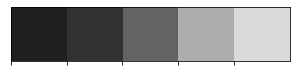

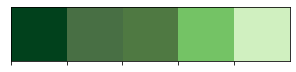

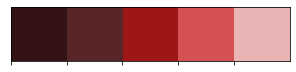

In [ ]:
colors_dark = ["#1F1F1F", "#313131", "#636363", "#AEAEAE", "#DADADA"]
colors_red = ["#331313", "#582626", "#9E1717", "#D35151", "#E9B4B4"]
colors_green = ["#01411C", "#486F44", "#4F7942", "#74C365", "#D0F0C0"]

sns.palplot(colors_dark)
sns.palplot(colors_green)
sns.palplot(colors_red)

In [ ]:
labels = ['carcinoma_in_situ','light_dysplastic','moderate_dysplastic','severe_dysplastic']

In [ ]:
labels[0]

'carcinoma_in_situ'

In [ ]:
x_train = []
y_train = []
image_size = 75
for i in labels:
    folderpath = os.path.join('/content/drive/MyDrive/smear2005/New database pictures/before_masking/abnormal',i)
    for j in tqdm(os.listdir(folderpath)):
        img = cv2.imread(os.path.join(folderpath, j))
        img = cv2.resize(img,(image_size, image_size))
        x_train.append(img)
        y_train.append(i)

x_train = np.array(x_train)
y_train = np.array(y_train)

100%|██████████| 197/197 [00:02<00:00, 97.93it/s] 


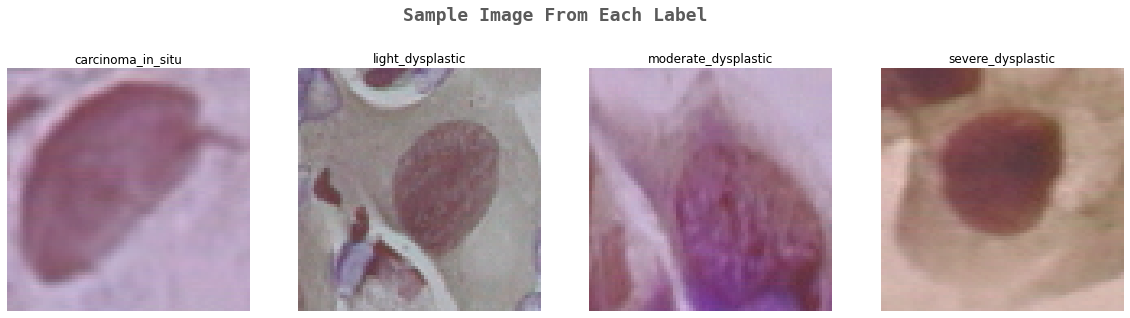

In [ ]:
k=0
fig, ax = plt.subplots(1,4,figsize=(20,20))
fig.text(s='Sample Image From Each Label', size=18, fontweight='bold',
         fontname='monospace', color=colors_dark[1], y=0.62, x=0.4, alpha=0.8)
for i in labels:
  j=0
  while True:
    if y_train[j]==i:
      ax[k].imshow(x_train[j])
      ax[k].set_title(y_train[j])
      ax[k].axis('off')
      k+=1
      break
    j+=1

In [ ]:
x_train, y_train = shuffle(x_train, y_train, random_state=101)

In [ ]:
x_train.shape

(675, 75, 75, 3)

In [ ]:
datagen = ImageDataGenerator(
    rotation_range = 30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True)

datagen.fit(x_train)
x_train.shape

(675, 75, 75, 3)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.2, random_state=101, stratify=y_train)


In [ ]:
y_train_new = []
for i in y_train:
  y_train_new.append(labels.index(i))
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)

y_test_new = []
for i in y_test:
  y_test_new.append(labels.index(i))
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

In [ ]:
model = keras.Sequential([
    
    layers.Conv2D(filters=32, kernel_size=(5,5), activation="relu", padding='same', input_shape=[75, 75, 3]),
    layers.MaxPool2D(),
    
    layers.Conv2D(filters=64, kernel_size=(3,3), activation="relu", padding='same'),
    layers.MaxPool2D(),
    
    layers.Conv2D(filters=128, kernel_size=(3,3), activation="relu", padding='same'),
    layers.MaxPool2D(),
    
    layers.Conv2D(filters=128, kernel_size=(3,3), activation="relu", padding='same'),
    layers.MaxPool2D(),
    
    layers.Flatten(),
    layers.Dropout(.25),
    layers.Dense(units=256, activation="relu"),
    layers.Dense(units=4, activation="softmax"),
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 75, 75, 32)        2432      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 37, 37, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 37, 37, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 18, 18, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 18, 18, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 9, 9, 128)        0

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(epsilon=0.01),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

#including early stopping to prevent overfitting
early_stopping = keras.callbacks.EarlyStopping(
    patience=10,
    min_delta=0.001,
    restore_best_weights=True,
)

In [ ]:
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint("model", monitor='val_accuracy', save_best_only=True, mode="auto", verbose=1)
reduce_lr =ReduceLROnPlateau(monitor= 'val_accuracy', factor=0.3, patience=2, min_delta=0.001, mode='auto', verbose=1)

In [ ]:
history = model.fit(x_train, y_train,validation_data=(x_test,y_test), epochs=150, verbose=1, batch_size=32,
                    callbacks=[tensorboard,checkpoint,reduce_lr])

Epoch 1/150
17/17 [==============================] - ETA: 0s - loss: 2.3557 - accuracy: 0.2648
Epoch 1: val_accuracy improved from -inf to 0.31111, saving model to model
INFO:tensorflow:Assets written to: model/assets
17/17 [==============================] - 12s 623ms/step - loss: 2.3557 - accuracy: 0.2648 - val_loss: 0.5667 - val_accuracy: 0.3111 - lr: 0.0010
Epoch 2/150
17/17 [==============================] - ETA: 0s - loss: 0.5687 - accuracy: 0.3481
Epoch 2: val_accuracy improved from 0.31111 to 0.40741, saving model to model
INFO:tensorflow:Assets written to: model/assets
17/17 [==============================] - 10s 578ms/step - loss: 0.5687 - accuracy: 0.3481 - val_loss: 0.5317 - val_accuracy: 0.4074 - lr: 0.0010
Epoch 3/150
17/17 [==============================] - ETA: 0s - loss: 0.5598 - accuracy: 0.3722
Epoch 3: val_accuracy did not improve from 0.40741
17/17 [==============================] - 10s 627ms/step - loss: 0.5598 - accuracy: 0.3722 - val_loss: 0.5270 - val_accuracy: 

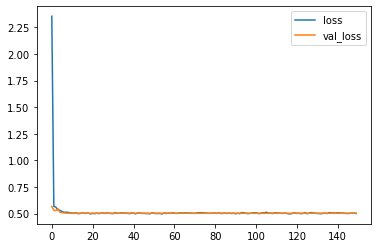

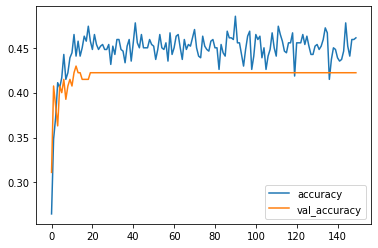

In [ ]:
history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss','val_loss']].plot()
history_frame.loc[:, ['accuracy','val_accuracy']].plot();

In [ ]:
pred = model.predict(x_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test, axis=1)

In [ ]:
print(classification_report(y_test_new,pred))

              precision    recall  f1-score   support

           0       0.74      0.57      0.64        30
           1       0.57      0.75      0.65        36
           2       0.44      0.28      0.34        29
           3       0.47      0.55      0.51        40

    accuracy                           0.55       135
   macro avg       0.56      0.54      0.53       135
weighted avg       0.55      0.55      0.54       135



In [ ]:
IMAGE_SIZE = [75,75]

#defining vgg16 model
vgg = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

#we have to take pre trained weights, we don't want to train the weights again
for layer in vgg.layers:
    layer.trainable = False

#flattening the output of vgg16 for fully connected layer.
x = tf.keras.layers.Flatten()(vgg.output)

#adding output layer
#x = Dense(1000, activation='relu')(x) here pretrained model had 1000 neurons but we'll be replacing them by 6(no. of classes)
prediction = tf.keras.layers.Dense(4, activation='softmax')(x)

In [ ]:
model = tf.keras.models.Model(inputs=vgg.input, outputs=prediction)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 75, 75, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 75, 75, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 75, 75, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 37, 37, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 37, 37, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 37, 37, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 18, 18, 128)       0   

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
tensorboard2 = TensorBoard(log_dir = 'logs')
checkpoint2 = ModelCheckpoint("vgg", monitor='val_accuracy', save_best_only=True, mode="auto", verbose=1)
reduce_lr2 =ReduceLROnPlateau(monitor= 'val_accuracy', factor=0.3, patience=2, min_delta=0.001, mode='auto', verbose=1)

In [ ]:
history1 = model.fit(x_train, y_train,validation_data=(x_test,y_test), epochs=100, verbose=1, batch_size=32,
                    callbacks=[tensorboard2,checkpoint2,reduce_lr2])

Epoch 1/100
17/17 [==============================] - ETA: 0s - loss: 6.2216 - accuracy: 0.3685
Epoch 1: val_accuracy improved from -inf to 0.46667, saving model to vgg
INFO:tensorflow:Assets written to: vgg/assets
17/17 [==============================] - 57s 3s/step - loss: 6.2216 - accuracy: 0.3685 - val_loss: 4.6362 - val_accuracy: 0.4667 - lr: 0.0010
Epoch 2/100
17/17 [==============================] - ETA: 0s - loss: 3.2274 - accuracy: 0.4981
Epoch 2: val_accuracy did not improve from 0.46667
17/17 [==============================] - 38s 2s/step - loss: 3.2274 - accuracy: 0.4981 - val_loss: 3.9879 - val_accuracy: 0.4519 - lr: 0.0010
Epoch 3/100
17/17 [==============================] - ETA: 0s - loss: 2.0240 - accuracy: 0.6204
Epoch 3: val_accuracy improved from 0.46667 to 0.48889, saving model to vgg
INFO:tensorflow:Assets written to: vgg/assets
17/17 [==============================] - 40s 2s/step - loss: 2.0240 - accuracy: 0.6204 - val_loss: 3.6081 - val_accuracy: 0.4889 - lr: 0.00

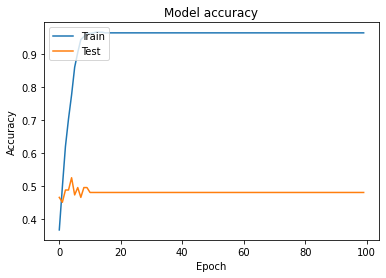

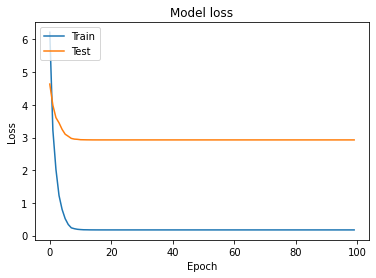

In [ ]:
plt.plot(history1.history['accuracy'])
plt.plot(history1.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
pred1 = model.predict(x_test)
pred1 = np.argmax(pred1,axis=1)
y_test_new1 = np.argmax(y_test, axis=1)

In [ ]:
print(classification_report(y_test_new1,pred1))

              precision    recall  f1-score   support

           0       0.57      0.57      0.57        30
           1       0.59      0.53      0.56        36
           2       0.31      0.38      0.34        29
           3       0.47      0.45      0.46        40

    accuracy                           0.48       135
   macro avg       0.49      0.48      0.48       135
weighted avg       0.49      0.48      0.49       135

